# Dataset Preprocessing
* This notebook is used for the data preprocessing of [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).    
* The preprocessed data is used to train a model for identity verification and face analytics.

## CelebA Dataset
CelebA dataset consists of triplets of images (anchor, positive, negative) used for face recognition in addition to analytic features describing each image such as: gender, hair color, glasses, age, ...   

## Preprocessing function
* images are resized, normalized and saved as numpy arrays.   
* Anchor images are matched to their triplets (positive and negative)
* Each anchor image is matched to its features that will be used in training which are age and gender.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/DEPI_Project'
dataset_path = '/content/Dataset'


Mounted at /content/drive


In [ ]:
# Unzip dataset images
! unzip /content/drive/MyDrive/DEPI_Project/archive.zip -d /content/Dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: /content/Dataset/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: /content/Dat

In [ ]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
import random

# Define Paths
images_path = os.path.join(dataset_path, 'img_align_celeba/img_align_celeba')  # Path to images
labels_path = os.path.join(dataset_path, 'list_attr_celeba.csv')               # Path to attributes CSV
ids_path = os.path.join(base_path, 'Dataset/identity_CelebA.txt')              # Path to identities txt file

# Load the Dataset attributes
attributes = pd.read_csv(labels_path)

# Load identities file (matching each image to its id)
with open(ids_path, 'r') as f:
  ids_mapping = f.read()

In [ ]:
# Convert the txt data to df to handle effectively
ids_list = ids_mapping.split('\n')
ids_mat = [n.split(' ') for n in ids_list]
ids_df = pd.DataFrame(ids_mat, columns=['image_path', 'id'])

# Take a subset of 20000 image to use for forming image triplets
subset_samples = 20000
ids_df = ids_df.sort_values('id')
ids_df = ids_df[:subset_samples]
ids_df = ids_df.reset_index(drop=True)
ids_df

,image_path,id
0,157602.jpg,1
1,117150.jpg,1
2,056279.jpg,1
3,024091.jpg,1
4,067855.jpg,1
...,...,...
19995,180648.jpg,1677
19996,180535.jpg,1677
19997,163546.jpg,1677
19998,180310.jpg,1677


In [ ]:
# Assign triplets (Match each image to a positive having the same id and a negative having a different random id)
triplets_df = pd.DataFrame(columns=['anchor', 'pos', 'neg', 'anchor_id', 'pos_id', 'neg_id'])

for index in ids_df.index:
  if(index == subset_samples-1):
    break
  if(ids_df['id'][index] != ids_df['id'][index+1]):
    continue
  anchor = ids_df['image_path'][index]
  pos = ids_df['image_path'][index+1]
  anchor_id = ids_df['id'][index]
  pos_id = ids_df['id'][index+1]
  if index < subset_samples/2:
    neg_idx = random.randint(index+50, subset_samples/2 + 50)
  else:
    neg_idx = random.randint(0, index-50)
  neg = ids_df['image_path'][neg_idx]
  neg_id = ids_df['id'][neg_idx]
  if(neg_id == pos_id):
    continue

  triplets_df = pd.concat([triplets_df, pd.DataFrame([{'anchor': anchor, 'pos': pos, 'neg': neg, 'anchor_id': anchor_id, 'pos_id': pos_id, 'neg_id': neg_id}])])

In [ ]:
# Select Relevant Attributes (For Gender and Age Classification)
attributes['Male'] = attributes['Male'].apply(lambda x: 1 if x == 1 else 0)
attributes['Young'] = attributes['Young'].apply(lambda x: 1 if x == 1 else 0)

# Filter relevant columns
selected_attributes = attributes[['image_id', 'Male', 'Young']]

In [ ]:
# Function to preprocess images: resize and normalize
def preprocess_image(image_path, id):
    try:
        # Open the image using PIL
        image = Image.open(image_path).convert('RGB')
        # Resize image to 75x75
        image = image.resize((75, 75))
        # Normalize pixel values (0-255 to 0-1)
        image = np.array(image) / 255.0
        return image, id
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None


In [ ]:
# Apply preprocessing to anchor, posiive and negative images
for type_id in ['anchor', 'pos', 'neg']:

    # Preprocess images using multithreading
    image_data = []
    labels_gender = []
    labels_age = []
    labels_id = []

    # Use ThreadPoolExecutor for concurrent image loading
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust the number of workers as needed
        futures = []

        # Anchor images processing
        for i, row in triplets_df.iterrows():
            image_path = os.path.join(images_path, row[type_id])
            futures.append(executor.submit(preprocess_image, image_path, row[type_id]))

        for i, future in enumerate(futures):
            result, id = future.result()
            if result is not None:
                image_data.append(result)
                attributes = selected_attributes.loc[selected_attributes['image_id'] == id]
                labels_id.append(id)                             # Save image id
                labels_gender.append(attributes['Male'].item())  # Get corresponding gender label
                labels_age.append(attributes['Young'].item())      # Get corresponding age label

    # Convert lists to numpy arrays
    image_data = np.array(image_data)
    labels_gender = np.array(labels_gender)
    labels_age = np.array(labels_age)
    labels_id = np.array(labels_id)

    # Save Preprocessed Data to Google Drive
    image_path = os.path.join(base_path, f'Matching_triplets/{type_id}_image.npy')
    gender_path = os.path.join(base_path, f'Matching_triplets/{type_id}_gender.npy')
    age_path = os.path.join(base_path, f'Matching_triplets/{type_id}_age.npy')
    id_path = os.path.join(base_path, f'Matching_triplets/{type_id}_id.npy')

    np.save(image_path, image_data)
    np.save(gender_path, labels_gender)
    np.save(age_path, labels_age)
    np.save(id_path, labels_id)

    # Output the shape of the datasets
    print(f"{type_id}_dataset: {image_data.shape}, {labels_gender.shape}, {labels_age.shape}")

anchor_dataset: (19068, 75, 75, 3), (19068,), (19068,)
pos_dataset: (19068, 75, 75, 3), (19068,), (19068,)
neg_dataset: (19068, 75, 75, 3), (19068,), (19068,)


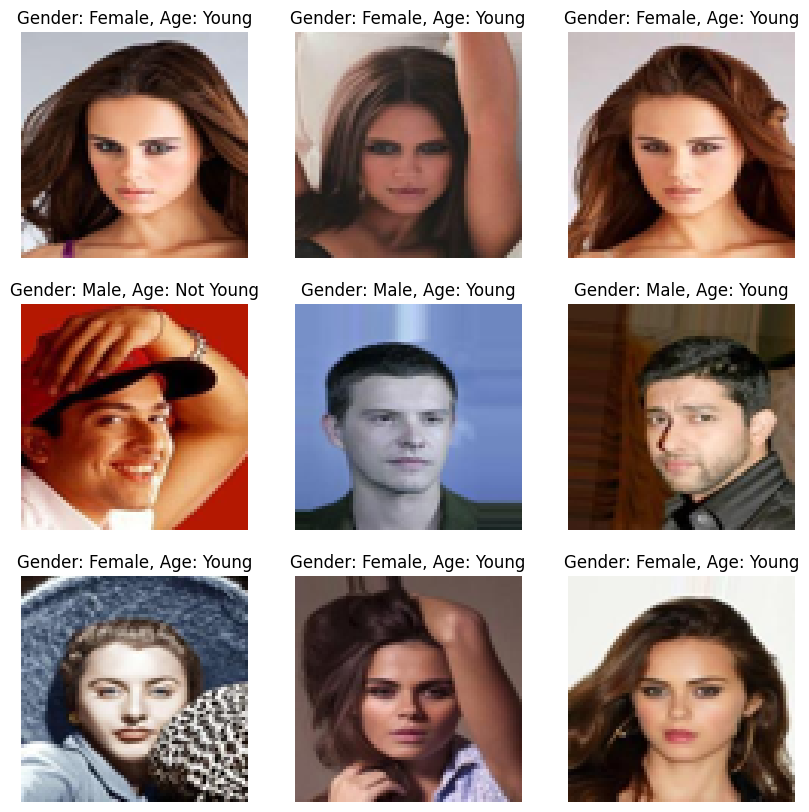

In [ ]:

# Optionally visualize some preprocessed images with their labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_data[i])
    plt.title(f"Gender: {'Male' if labels_gender[i] == 1 else 'Female'}, Age: {'Young' if labels_age[i] == 1 else 'Not Young'}")
    plt.axis('off')
plt.show()


## Dataset statistics

([<matplotlib.patches.Wedge at 0x7a9dad8e5d50>,
 [Text(-0.8308835148215306, 0.7208554534702638, 'male'),
  Text(0.8308835485672088, -0.7208554145737985, 'female')],
 [Text(-0.45320918990265296, 0.39319388371105296, '77.3%'),
  Text(0.45320920830938655, -0.3931938624947992, '22.7%')])

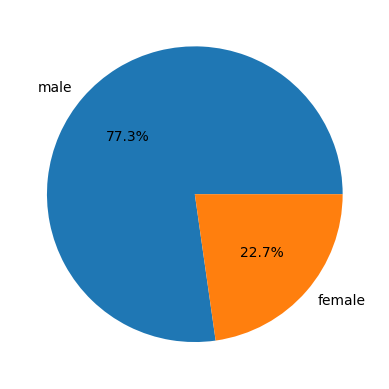

In [ ]:
# Male / Female distribution in anchor images
age_path = os.path.join(base_path, f'Matching_triplets/anchor_age.npy')
anchor_age = np.load(age_path)
male_portion = anchor_age.sum()
female_portion = len(anchor_age) - male_portion
plt.pie([male_portion, female_portion], labels=['male', 'female'], autopct='%1.1f%%',)

([<matplotlib.patches.Wedge at 0x7a9da1c2fd00>,
 [Text(0.2813734743605446, 1.0634044235032485, 'young'),
  Text(-0.28137347436054444, -1.0634044235032485, 'not_young')],
 [Text(0.15347644056029702, 0.5800387764563173, '41.8%'),
  Text(-0.15347644056029697, -0.5800387764563173, '58.2%')])

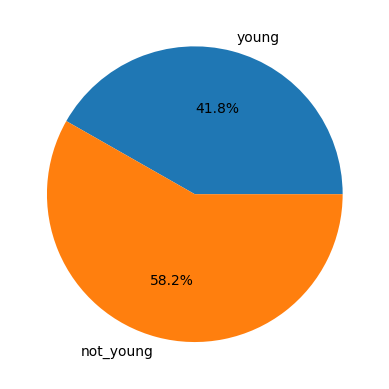

In [ ]:
# Young / Not-young distribution in anchor images
gender_path = os.path.join(base_path, f'Matching_triplets/anchor_gender.npy')
anchor_gender = np.load(gender_path)
young_portion = anchor_gender.sum()
old_portion = len(anchor_age) - young_portion
plt.pie([young_portion, old_portion], labels=['young', 'not_young'], autopct='%1.1f%%',)